# 1. Importovanje biblioteka

In [2]:
import mlflow
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.image as mpimg
import math

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Povezivanje na mlflow bazu
 
Ovim kodom dobavljamo sve eksperimente tj. run-ove pod eksperimentom "Emotion_Detection_Transformers". Uzimamo definisane kolone koje ćemo koristiti i dalje i pravimo dve tabele. Jednu koja je sortirana po accuracz i jednu koja je sortirana po f1 score.

In [3]:
mlflow.set_tracking_uri("sqlite:///../mlflow.db")

EXP_NAME = "Emotion_Detection_Transformers"

experiment = mlflow.get_experiment_by_name(EXP_NAME)

if experiment is None:
    print("Eksperiment nije pronadjen! Pogrsno ime ili putanja do baze.")
else:
    df = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="attributes.status = 'FINISHED'"
    )
    
    cols_to_keep = [
        'tags.mlflow.runName', 
        'params.model',
        'params.description',
        'params.learning_rate', 
        'params.batch_size', 
        'params.max_len',
        'params.optimizer',
        'metrics.avg_accuracy', 
        'metrics.avg_f1', 
        'metrics.avg_train_time_sec',
        'metrics.model_size_mb',
        'artifact_uri',
        'end_time'
    ]
    
    existing_cols = [c for c in cols_to_keep if c in df.columns]
    df_filtered = df[existing_cols].copy()
    
    rename_map = {
        'tags.mlflow.runName': 'Name',
        'params.description': 'Description',
        'params.model': 'Model',
        'params.learning_rate': 'LR',
        'params.batch_size': 'Batch',
        'params.max_len': 'Len',
        'metrics.avg_accuracy': 'Accuracy',
        'metrics.avg_f1': 'F1 Score',
        'metrics.avg_train_time_sec': 'Time(s)',
        'metrics.model_size_mb': 'Size(MB)'
    }
    df_filtered = df_filtered.rename(columns=rename_map)

    #filtriramo prethodne probne eksperimente po nazivu
    #novi imaju timestamp u imenu i konzistentne metrike
    timestamp_pattern = r'\d{8}_\d{6}'
    df_filtered = df_filtered[df_filtered['Name'].str.contains(timestamp_pattern, regex=True)]
    
    #kolone koje ne prikazujemo
    cols_to_hide = ['artifact_uri', 'end_time']

    #tabela sortirana po f1 score
    df_f1 = df_filtered.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
    df_display_f1 = df_f1.drop(columns=[c for c in cols_to_hide if c in df_f1.columns])

    #tabela sortirana po accuracy
    df_acc = df_filtered.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
    df_display_acc = df_acc.drop(columns=[c for c in cols_to_hide if c in df_acc.columns])
    
    print(f"Ukupno pronadjeno {len(df_filtered)} uspesnih run-ova.\n")
    
    def style_table(dataframe):
        return dataframe.style.background_gradient(subset=['Accuracy', 'F1 Score'], cmap='Greens') \
            .format({'Accuracy': '{:.4f}', 'F1 Score': '{:.4f}', 'Time(s)': '{:.1f}'}) \
            .set_properties(**{'text-align': 'left'}) \
            .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])


    print("Tabela rangirana prema F1 Score")
    display(style_table(df_display_f1))
    
    print("Tabela rangirana prema Accuracy")
    display(style_table(df_display_acc))

Ukupno pronadjeno 8 uspesnih run-ova.

Tabela rangirana prema F1 Score


,Name,Model,Description,LR,Batch,Len,Accuracy,F1 Score,Time(s),Size(MB)
0,Bert_Tiny_20260224_224237,bert-tiny,"Optimizovani parametri, 4 folda, 4 epohe",2e-05,32,128,0.9854,0.9854,291.1,16.742214
1,Bert_Mini_20260224_233549,bert-mini,"Bert Mini, optimalni hiperparametri",2e-05,64,64,0.9831,0.9831,320.4,42.626980
2,Bert_Tiny_20260225_001750,bert-tiny,"Bert Tiny, hiperparametri optimizivani za preciznost",2e-05,32,128,0.9783,0.9783,187.7,16.742214
3,Bert_Tiny_20260224_204912,bert-tiny,"max_len je sada 32 umsto 128, model ce gledati samo prvih tridesetak reci, trening bi trebalo da bude brzi",2e-05,32,32,0.9412,0.9413,81.2,16.742214
4,Bert_Tiny_20260224_231135,bert-tiny,"Brzo treniranje, manja tacnost",5e-05,64,20,0.8944,0.8943,26.5,16.742214
5,Bert_Tiny_20260225_005311,bert-tiny,Test crtanja learning curve-a,5e-05,64,16,0.8594,0.8594,18.8,16.742214
6,Bert_Tiny_20260224_221622,bert-tiny,"Amnezija - Kratak kontekst, model ce videti samo prvih 5 reci",2e-05,32,6,0.7912,0.7908,69.0,16.742214
7,Bert_Tiny_20260224_211624,bert-tiny,"Eksplozija - Preveliki learning rate, ROC kriva bi trebalo da bude blize dijagonali, loss f-ja bi trebalo da osciluje",0.01,16,128,0.1413,0.0613,982.5,16.742214


Tabela rangirana prema Accuracy


,Name,Model,Description,LR,Batch,Len,Accuracy,F1 Score,Time(s),Size(MB)
0,Bert_Tiny_20260224_224237,bert-tiny,"Optimizovani parametri, 4 folda, 4 epohe",2e-05,32,128,0.9854,0.9854,291.1,16.742214
1,Bert_Mini_20260224_233549,bert-mini,"Bert Mini, optimalni hiperparametri",2e-05,64,64,0.9831,0.9831,320.4,42.626980
2,Bert_Tiny_20260225_001750,bert-tiny,"Bert Tiny, hiperparametri optimizivani za preciznost",2e-05,32,128,0.9783,0.9783,187.7,16.742214
3,Bert_Tiny_20260224_204912,bert-tiny,"max_len je sada 32 umsto 128, model ce gledati samo prvih tridesetak reci, trening bi trebalo da bude brzi",2e-05,32,32,0.9412,0.9413,81.2,16.742214
4,Bert_Tiny_20260224_231135,bert-tiny,"Brzo treniranje, manja tacnost",5e-05,64,20,0.8944,0.8943,26.5,16.742214
5,Bert_Tiny_20260225_005311,bert-tiny,Test crtanja learning curve-a,5e-05,64,16,0.8594,0.8594,18.8,16.742214
6,Bert_Tiny_20260224_221622,bert-tiny,"Amnezija - Kratak kontekst, model ce videti samo prvih 5 reci",2e-05,32,6,0.7912,0.7908,69.0,16.742214
7,Bert_Tiny_20260224_211624,bert-tiny,"Eksplozija - Preveliki learning rate, ROC kriva bi trebalo da bude blize dijagonali, loss f-ja bi trebalo da osciluje",0.01,16,128,0.1413,0.0613,982.5,16.742214


U ove dve tabele se može videti rangiranje izvršenih eksperimenata sa najbitinijim metrikama i rezultatima. Prva tabela pokazuje rangiranje prema f1 score-u, a druga prema accuracy. U obe tabele, može se videti da je jedan isti model najbolje rangiran (bert-tiny koji je radio sa 4 folda i 4 epohe po foldu). Odmah nakon njega je bert-mini, jači model, međutim, njegovo treniranje traje duže uz 3 folda i 3 epohe po foldu. Trajanje folda je malo duže od bert-tiny modela, ali su rezultati veoma slični.

# 3. Prikaz reprezentativnih eksperimenata

U kodu ispod, definisani su izdvojeni reprezentativni eksperimenti. Preuzimaju se artifakti sa mlflow-a i definiše se funkcija za crtanje grafikona. Prva tri eksperimanta su namenski optimizovana za bolje rezultate, dok su naredna četiri demonstratine prirode i demonstriraju šta se dešava kada se određeni hiperparametri podese na drugačije vrednosti.

Eksperimenti su redom:
- Bert_Tiny_20260225_001750 - Prvobitno je podešen na optimalne hiperparametre (uzimanjući u obzir da se treniranje radi na cpu), međutim nije dao najbolje rezultate, ali je bio relativno brz.
- Bert_Tiny_20260224_224237 - Ovaj eksperiment je dao najbolju tačnost od 0.9854. Radio je u 4 folda sa po 4 epohe po foldu uz optimalne hiperparametre.
- Bert_Mini_20260224_233549 - Ovaj eksperiment je koristio drugi model, bert-mini, koji je više nego duplo veći od bert-tiny modela koji je korišćena za druge eksperimente. Treniranje ovog modela traje duže, a pruža veoma slične rezultate kao bert-tiny.
- Bert_Tiny_20260224_204912 - U ovom eksperimentu, length je smanjen na 32, što znači da će model gledati prvih tridesetak reči. Ovo značajno smanjuje vreme treniranja, ali malo ismanjuje preciznost koja je sada 0.9412 što znači da je prvih tridesetak reči uglavnom više nego dovoljno da se detektuje emocija u datom datasetu.
- Bert_Tiny_20260224_231135 - Ovaj eksperiment je namenski optimizovan za što manje vreme treniranja. Radio je u samo 2 folda i 2 epohe po foldu sa length-om od samo 20, ali je uprkos tome preciznost bila skoro 0.9
- Bert_Tiny_20260224_221622 - U ovom eksperimentu, length je bio podešen na samo 6, što znači da je model video samo prvih 5 reči. Accuracy je očekivano bio manji ali imajući u vidu ovoliko mali kontekst, preciznost je bila solidna sa 0.7912 uz veoma kratko vreme treniranja.
- Bert_Tiny_20260224_211624 - Learning rate u ovom eksperimentu je bio podešen na veliku vrednost. Ovaj eksperiment je dao ubedljivo najgore rezultate sa najvećim vremenom treniranja i najmanjom preciznošću od samo 0.1413

In [8]:
target_run_names = [
    "Bert_Tiny_20260225_001750", 
    "Bert_Tiny_20260224_224237", 
    "Bert_Mini_20260224_233549", 
    "Bert_Tiny_20260224_204912", 
    "Bert_Tiny_20260224_231135", 
    "Bert_Tiny_20260224_221622", 
    "Bert_Tiny_20260224_211624"  
]

run_descriptions = {
    "Bert_Tiny_20260225_001750": "Tiny - Preciznost (3 epohe)",
    "Bert_Tiny_20260224_224237": "Tiny - Najbolji Accuracy (4 epohe)",
    "Bert_Mini_20260224_233549": "Mini - Optimalni",
    "Bert_Tiny_20260224_204912": "Tiny - Kratak Len (32)",
    "Bert_Tiny_20260224_231135": "Tiny - Najbrzi",
    "Bert_Tiny_20260224_221622": "Tiny - Amnezija (Vidi prvih 5 reci)",
    "Bert_Tiny_20260224_211624": "Tiny - Eksplozija (High LR)"
}

run_data = []

print("Prikupljanje grafika i parametara...")

for name in target_run_names:
    run_row = df[df['tags.mlflow.runName'].str.contains(name, regex=False)]
    
    if run_row.empty:
        print(f"Run '{name}' nije pronadjen u DataFrame-u.")
        continue
    
    row = run_row.iloc[0]
    run_id = row['run_id']
    full_name = row['tags.mlflow.runName']
    
    params = {
        "Model": row.get('params.model', 'N/A'),
        "LR": row.get('params.learning_rate', 'N/A'),
        "Batch": row.get('params.batch_size', 'N/A'),
        "Len": row.get('params.max_len', 'N/A'),
        "Acc": row.get('metrics.avg_accuracy', 0.0),
        "F1": row.get('metrics.avg_f1', 0.0),
        "Time": row.get('metrics.avg_train_time_sec', 0.0),
        "ModelSize": row.get('metrics.model_size_mb', 0.0)
    }

    artifacts = {}
    for img_name in ["confusion_matrix.png", "learning_curve.png", "roc_curve.png"]:
        try:
            local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=img_name)
            artifacts[img_name] = local_path
        except Exception:
            artifacts[img_name] = None
            
    run_data.append({
        "name": full_name,
        "desc": run_descriptions.get(name, name),
        "params": params,
        "images": artifacts
    })

print(f"Podaci prikupljeni za {len(run_data)} run-ova.")

def plot_grid(data_list, image_key, title_main):
    n = len(data_list)
    cols = 3
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 7 * rows))
    fig.suptitle(title_main, fontsize=24, y=1.02)
    axes = axes.flatten()
    
    for i, item in enumerate(data_list):
        ax = axes[i]
        img_path = item['images'].get(image_key)
        
        if img_path:
            img = mpimg.imread(img_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Nema slike", ha='center', va='center')
            
        ax.axis('off')
        
        ax.set_title(item['desc'], fontsize=16, fontweight='bold', pad=20)
        
        p = item['params']
        acc_val = f"{float(p['Acc']):.3f}" if p['Acc'] != 'N/A' else 'N/A'
        f1_val = f"{float(p['F1']):.3f}" if p['F1'] != 'N/A' else 'N/A'
        
        param_text = (
            f"Model: {p['Model']} | LR: {p['LR']} | Len: {p['Len']}\n"
            f"Acc: {acc_val} | F1: {f1_val} | Time: {p['Time']:.1f}s | Model Size: {p['ModelSize']:.1f}MB"
        )
        ax.text(0.5, -0.15, param_text, transform=ax.transAxes, 
                ha='center', va='top', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", fc="#f0f0f0", ec="gray", alpha=0.5))

    for i in range(len(data_list), len(axes)):
        axes[i].axis('off')

    plt.subplots_adjust(top=0.92, bottom=0.05, hspace=0.5, wspace=0.2)
    plt.show()

Prikupljanje grafika i parametara...


Podaci prikupljeni za 7 run-ova.


## Matrice konfuzije

Matrice konfuzije su jedan od najboljih vizuelnih prikaza tačnosti modela. Prikazuju odnos između predviđenih i stvarnih vrednosti. U rezultatu izvršavanja koda ispod se mogu i videti.

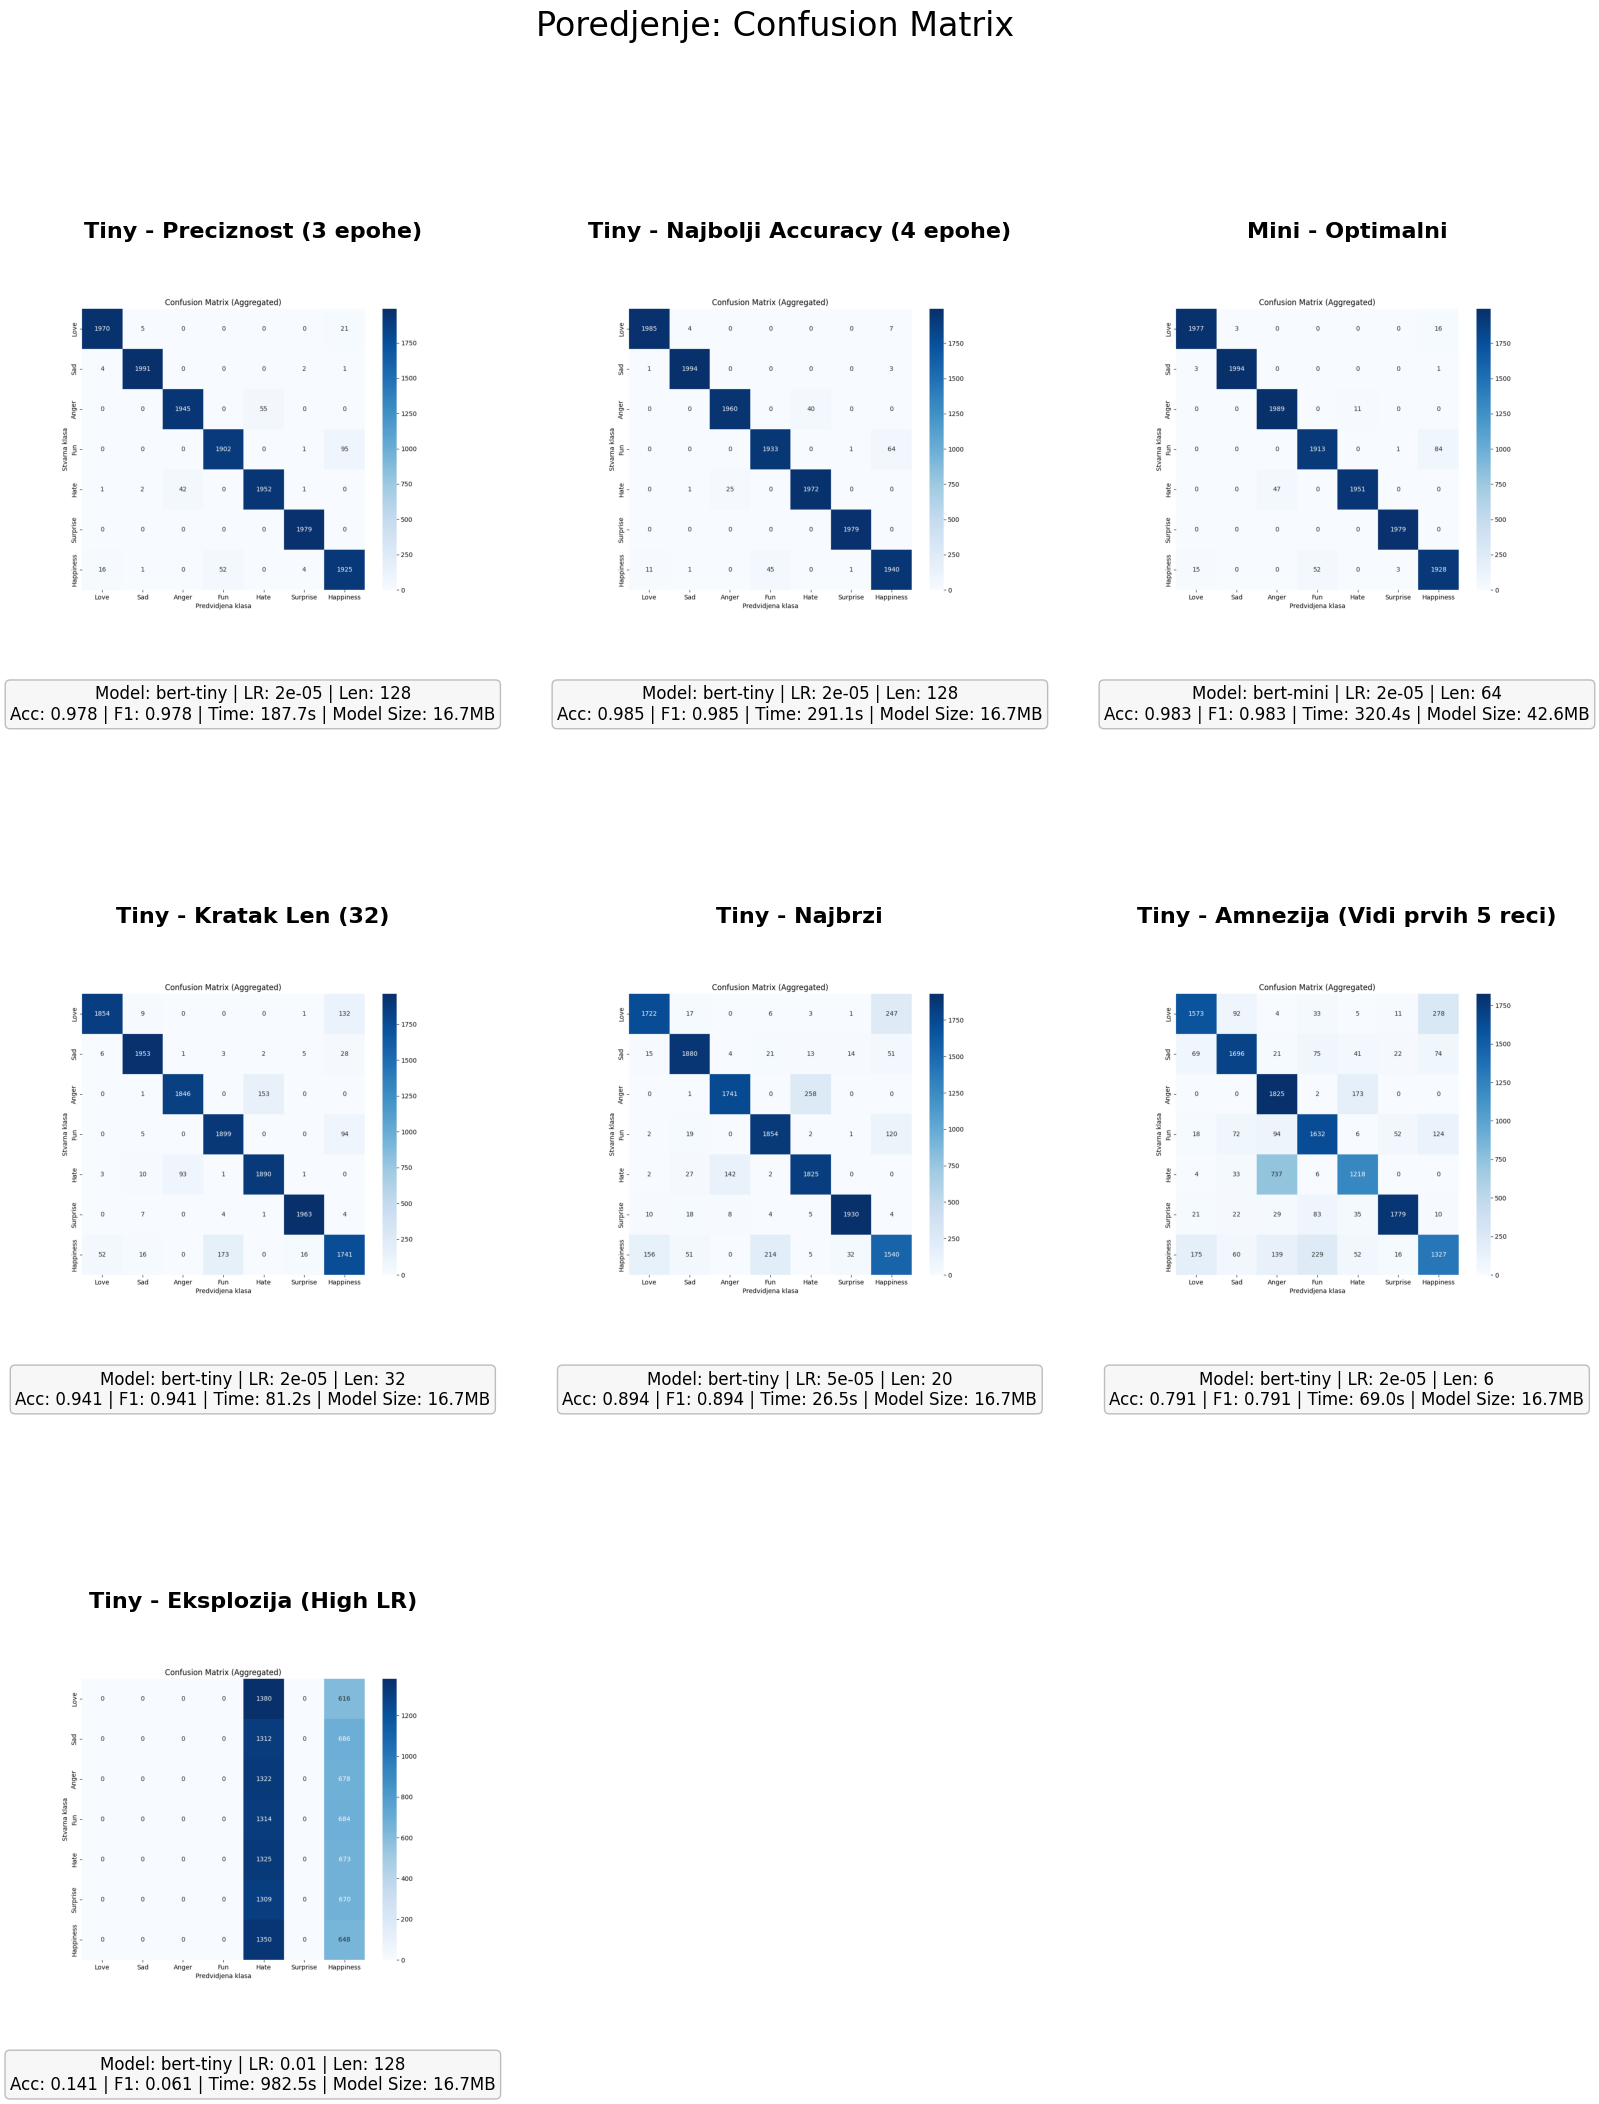

In [9]:
plot_grid(run_data, "confusion_matrix.png", "Poredjenje: Confusion Matrix")

Kao reprezentativni i zanimljivi grafikoni, izdvajaju se:
- bert-tiny sa najboljom tačnošću (drugi grafikon). Može se primetiti jaka dijagonala što ukazuje na izuzetnu preciznost gde je model skoro ouvek tačno predvideo klasu.
- tiny-najbrži - Na ovom grafikonu se već može videti malo manja preciznost modela, ali uglavnom tačno pogađa
- tiny-amnezija - Ovaj grafikon prikazuje reprezentativno manju preciznost, mogu se videti parovi emocija koje model najčešće meša: hate i anger kao i happiness i love, što se moglo očekivati.
- tiny-eksplozija - Na ovoj matrici konfuzije, može se videti šta se dešava kada je learning rate preveliki. Model je sve emocije klasifikovao ili kao hate ili kao happiness.

## Learning curve

Još jedan koristan grafikon. Prikazuje gubitak po epohama i foldovima. Kod dobro treniranog modela, gubitak se smanjuje posle svake epohe. U rezultatima ispod se može videti i kako learning curve izgleda i kada to nije slučaj.

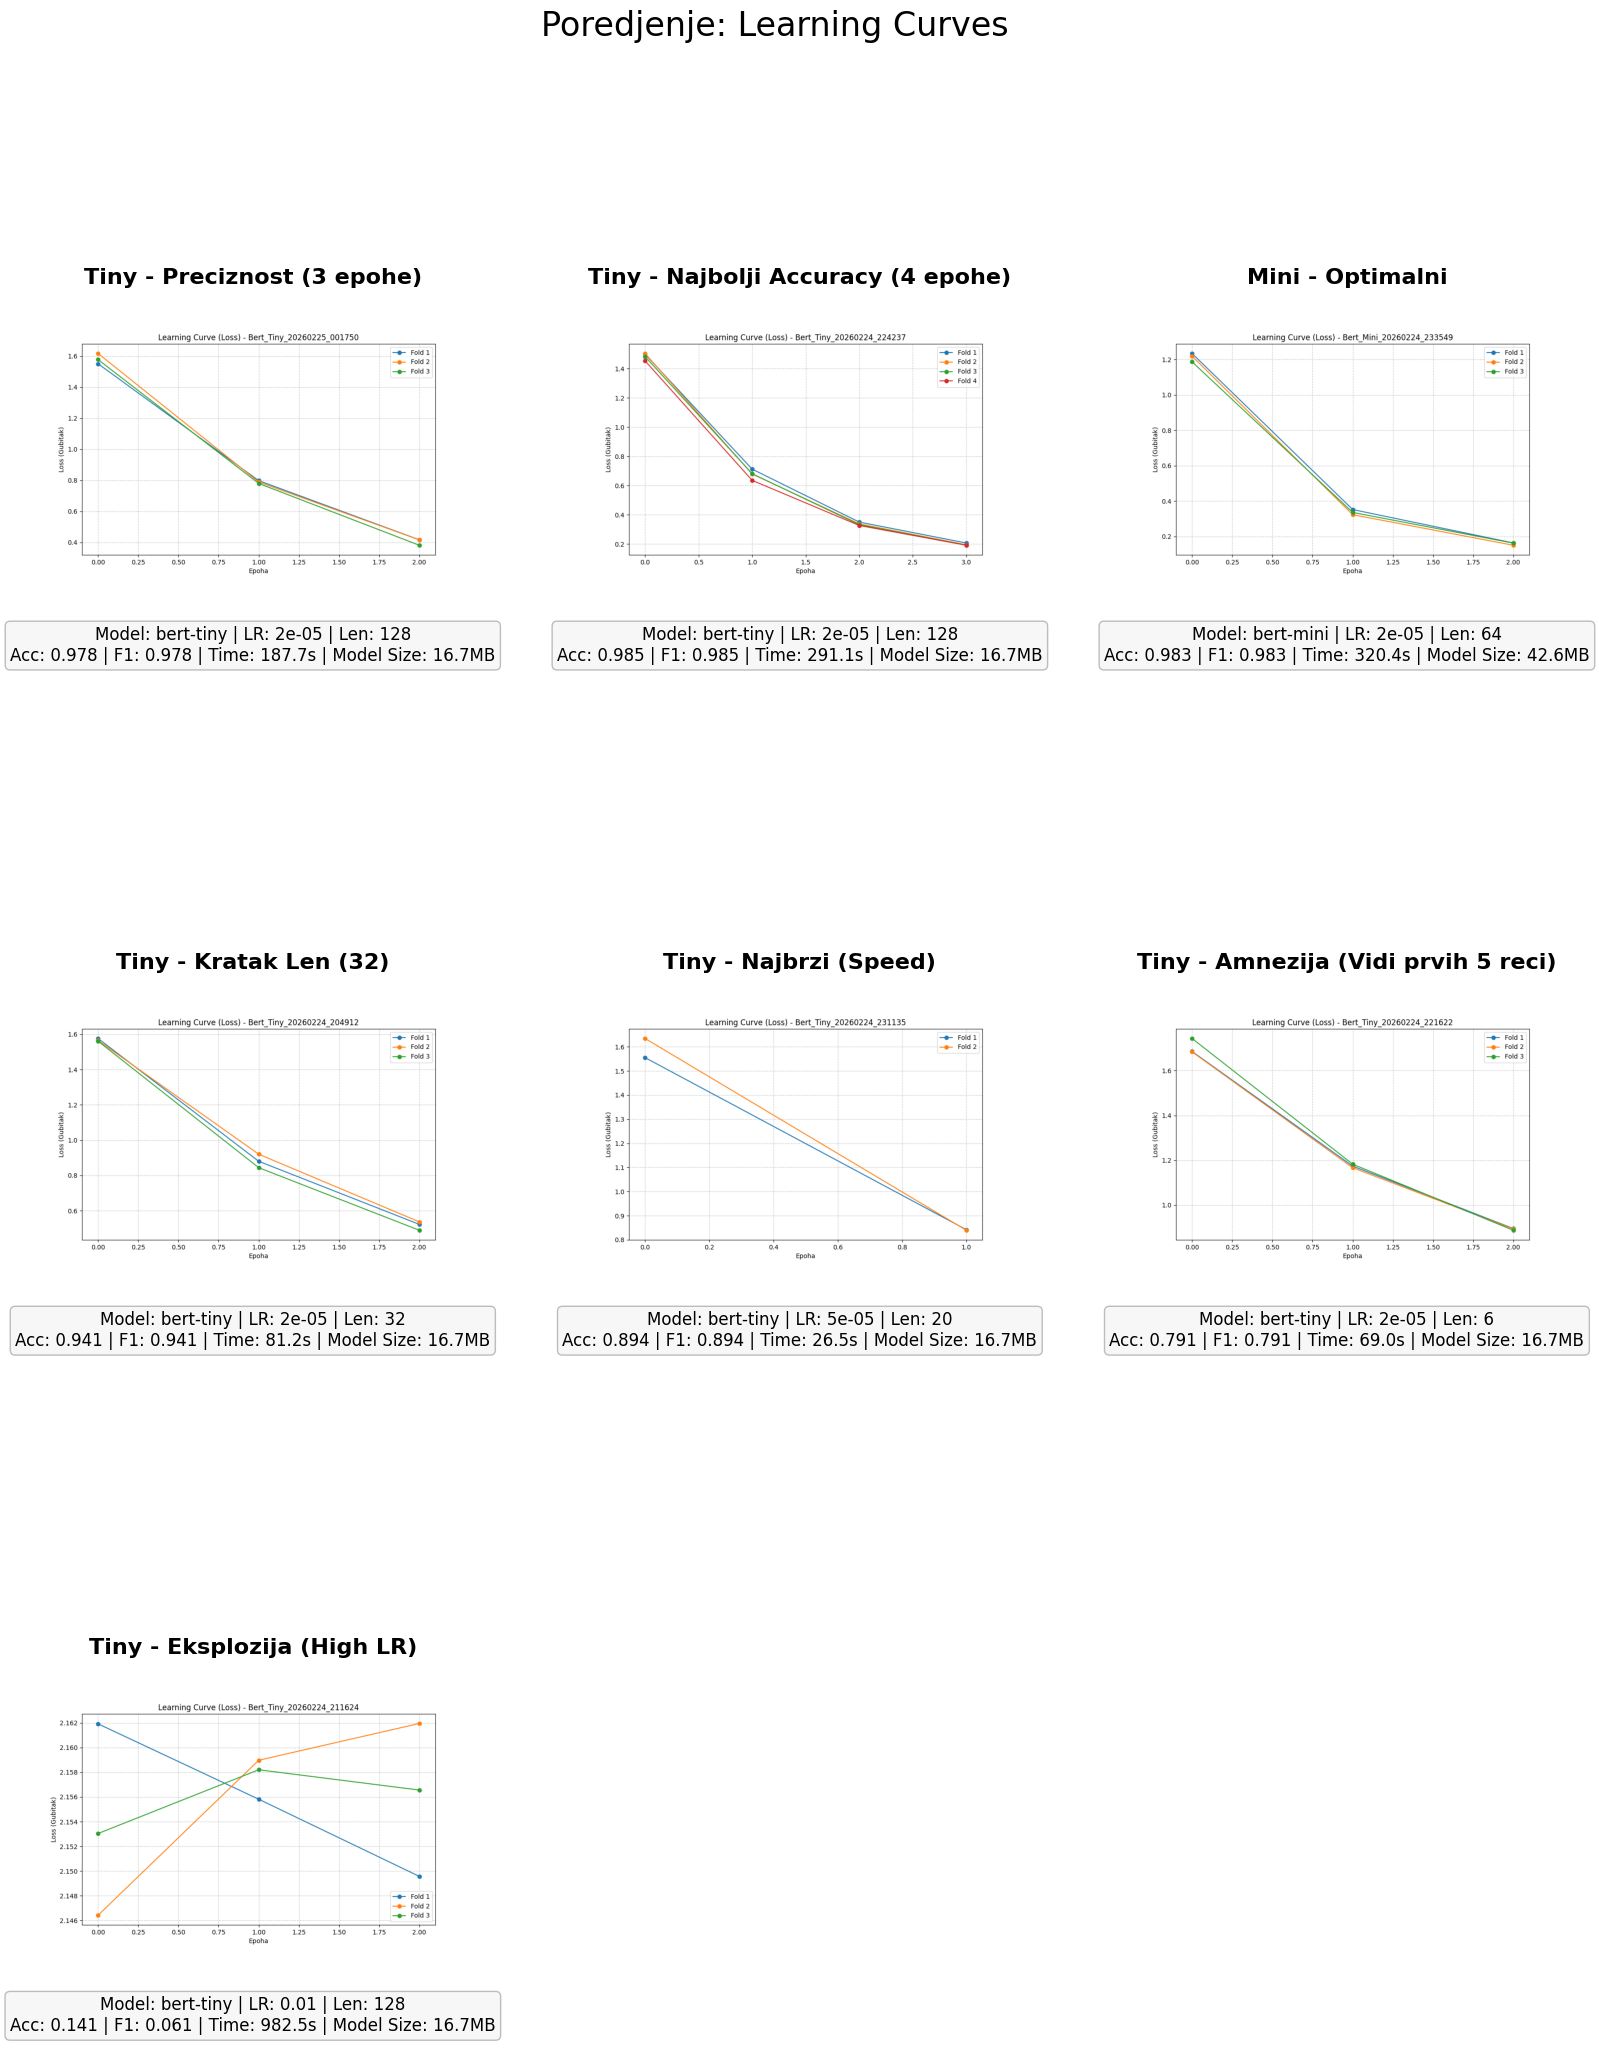

In [6]:
plot_grid(run_data, "learning_curve.png", "Poredjenje: Learning Curves")

Na svim grafikonima osim poslednjeg, može se videti da kako epohe odmiču, tako se i gubitak smanjuje. U eksperimentu sa najboljom tačnošću (4 folda i 4 epohe po foldu) se ovo možda i najbolje vidi. Gubitak se prvo smanjuje brzo a onda sporije.

Sa druge strane, na poslednjem primeru se može videti kako izgleda learnign curve kada je learnign rate preveliki. Sva tri folda daju različit tok gubitka, jedan raste, drugi pada, a treči osciluje.

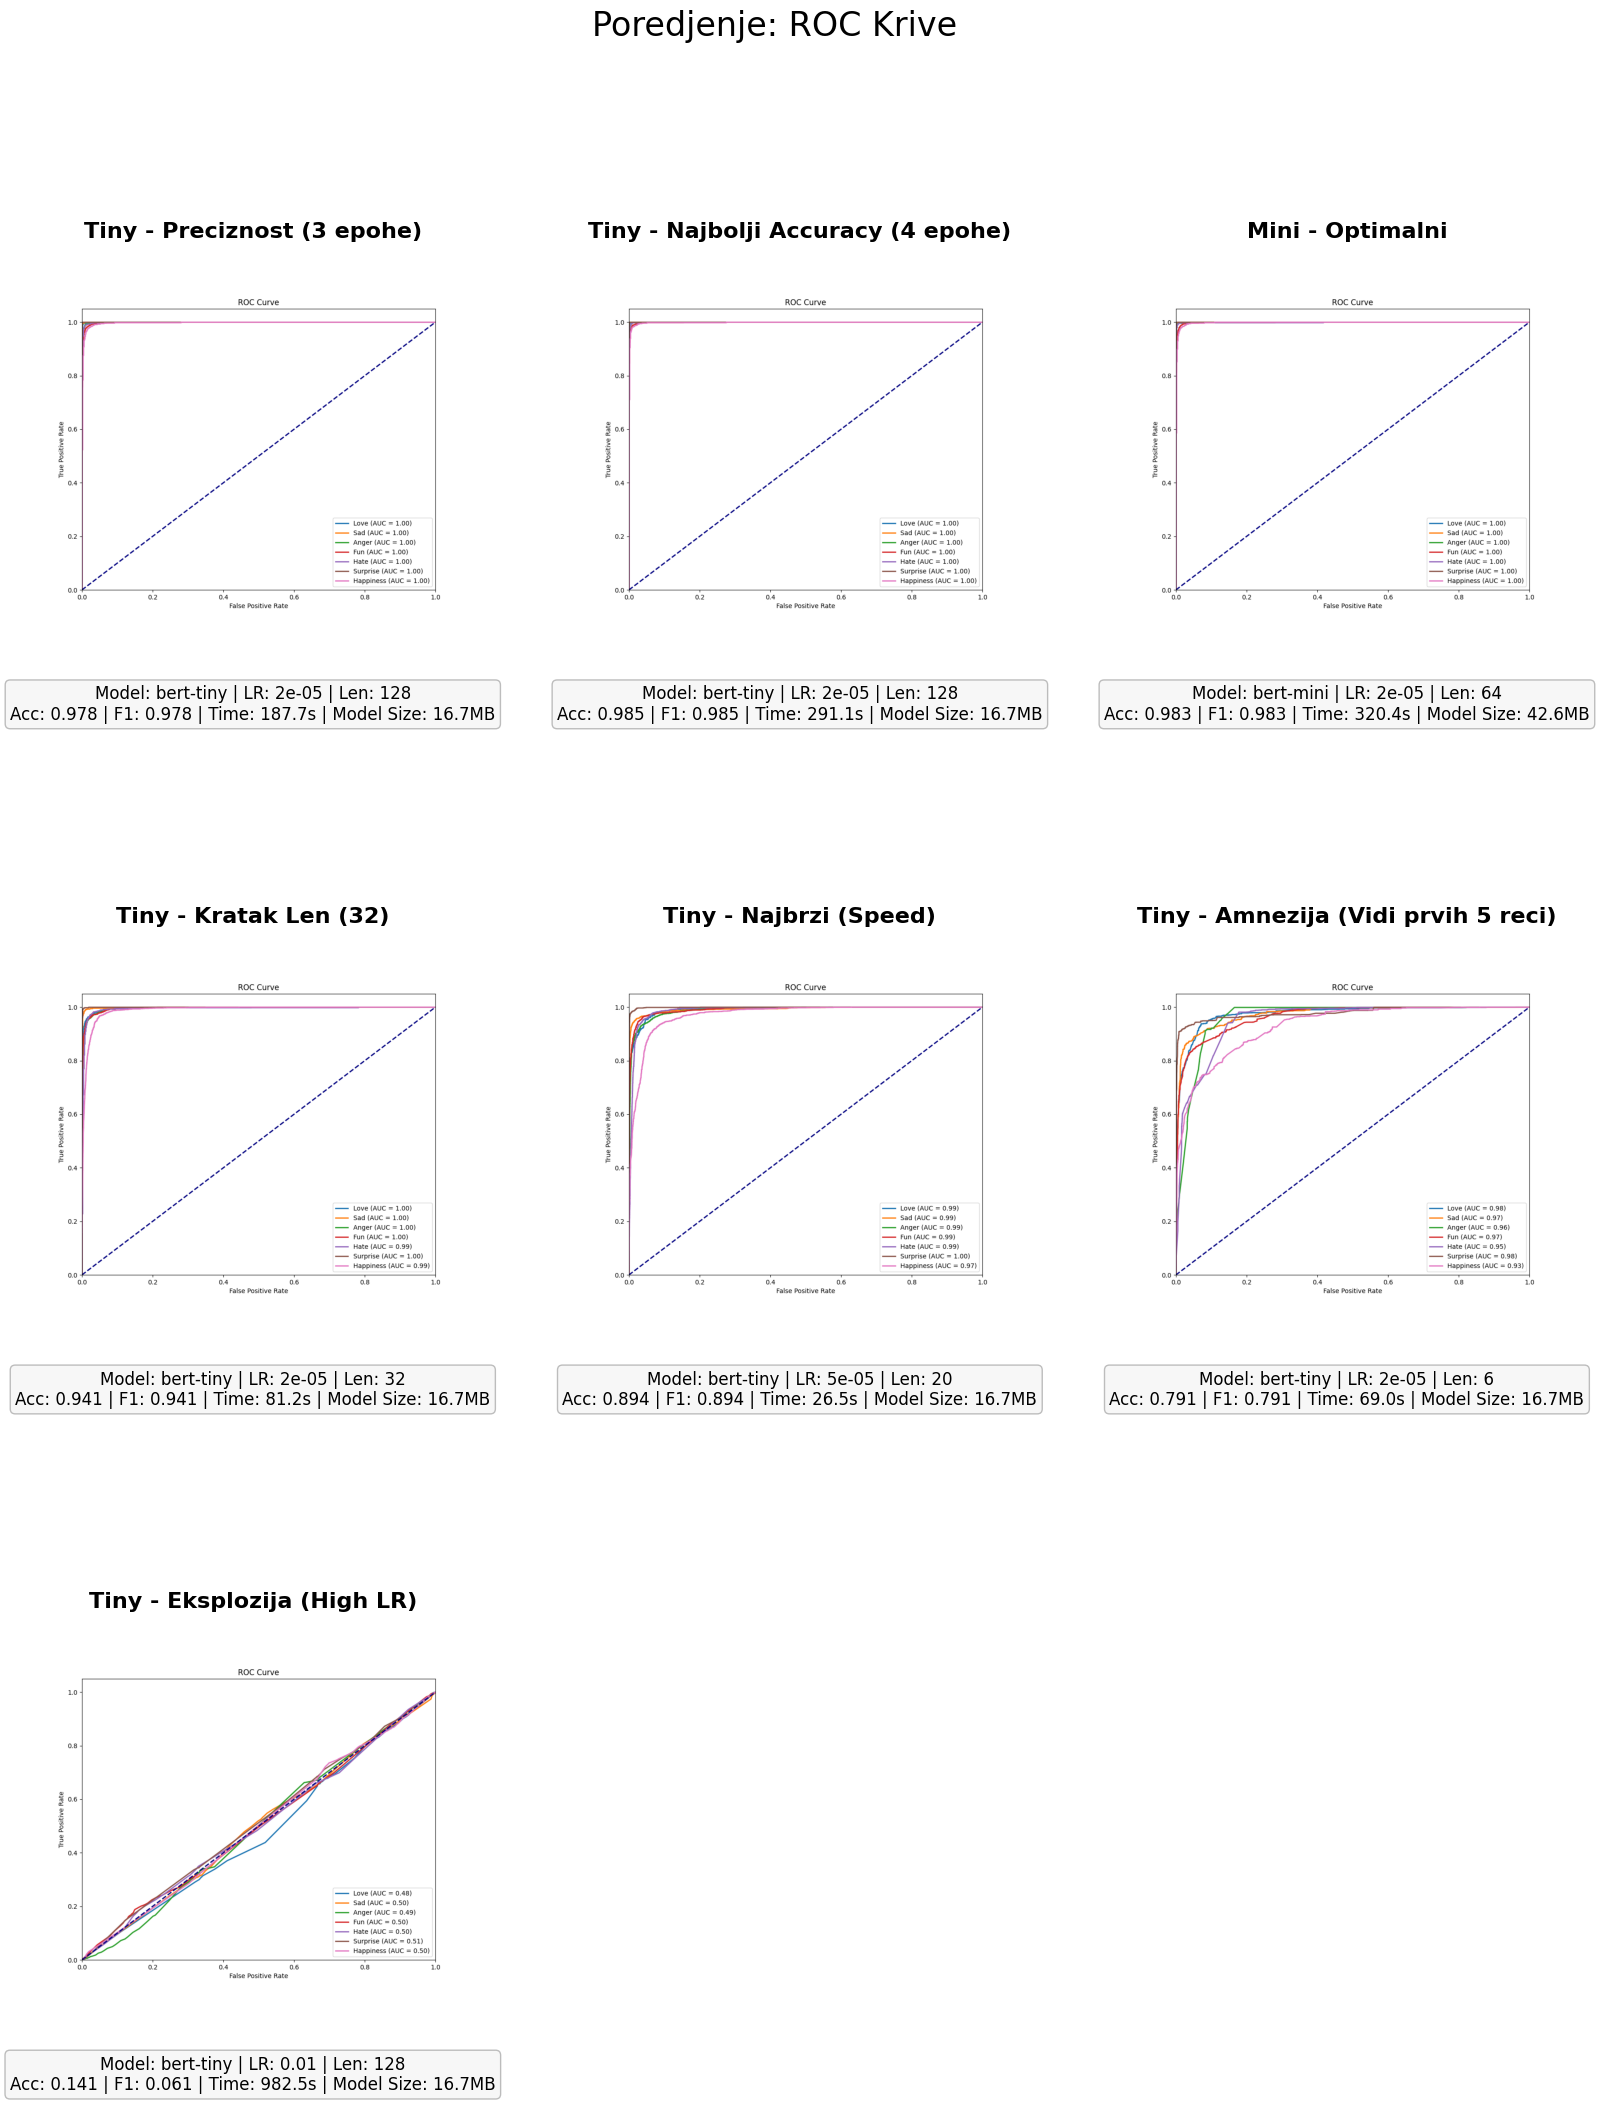

In [7]:
plot_grid(run_data, "roc_curve.png", "Poredjenje: ROC Krive")